In [1]:
from fastai.vision.all import *
from pathlib import Path


import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')


In [2]:
!wget "https://data.mendeley.com/public-files/datasets/4r4v785rgx/files/132306f6-26f4-4583-8f1b-ccc5ad8da05d/file_downloaded"

--2023-04-17 08:17:02--  https://data.mendeley.com/public-files/datasets/4r4v785rgx/files/132306f6-26f4-4583-8f1b-ccc5ad8da05d/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/1cc91ea1-80ef-4776-a573-58cc8343c9ce [following]
--2023-04-17 08:17:03--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/1cc91ea1-80ef-4776-a573-58cc8343c9ce
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.92.128, 52.218.98.64, 52.218.116.74, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.92.128|:

In [3]:
import h5py
import numpy as np

class MyData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.datasets = {}

    def read_data(self):
        with h5py.File(self.file_path, 'r') as file:
            for key in file.keys():
                self.datasets[key] = file[key][:]

def create_subsets(input_file_path, output_file_path_1, output_file_path_2, percentage):
    data_obj = MyData(input_file_path)
    data_obj.read_data()

    # Get indices of rows with signal 0 and 1
    idx_0 = np.where(data_obj.datasets['signal'] == 0)[0]
    idx_1 = np.where(data_obj.datasets['signal'] == 1)[0]

    # Calculate the number of rows for each signal value based on the percentage
    n_rows_0 = int(len(idx_0) * percentage)
    n_rows_1 = int(len(idx_1) * percentage)

    # Randomly choose rows for each signal value without replacement
    selected_idx_0 = np.random.choice(idx_0, n_rows_0, replace=False)
    selected_idx_1 = np.random.choice(idx_1, n_rows_1, replace=False)

    # Combine the selected indices and shuffle them
    selected_indices = np.concatenate((selected_idx_0, selected_idx_1))
    np.random.shuffle(selected_indices)
    selected_indices.sort()  # Sort the selected indices in increasing order

    # Get the remaining indices
    remaining_indices = np.setdiff1d(np.arange(len(data_obj.datasets['signal'])), selected_indices)
    remaining_indices.sort()

    # Write the selected data to the first output file
    with h5py.File(output_file_path_1, 'w') as output_file_1:
        for key in data_obj.datasets:
            dataset_shape = (len(selected_indices),) + data_obj.datasets[key].shape[1:]
            dataset_subset = output_file_1.create_dataset(key, dataset_shape, dtype=data_obj.datasets[key].dtype)
            dataset_subset[:] = data_obj.datasets[key][selected_indices]

    # Write the remaining data to the second output file
    with h5py.File(output_file_path_2, 'w') as output_file_2:
        for key in data_obj.datasets:
            dataset_shape = (len(remaining_indices),) + data_obj.datasets[key].shape[1:]
            dataset_subset = output_file_2.create_dataset(key, dataset_shape, dtype=data_obj.datasets[key].dtype)
            dataset_subset[:] = data_obj.datasets[key][remaining_indices]



In [4]:
input_file_path = "/kaggle/working/file_downloaded"
output_file_path_1 = "jet-images_test.hdf5"
output_file_path_2 = "jet-images_90.hdf5"
percentage = 0.1

create_subsets(input_file_path, output_file_path_1, output_file_path_2, percentage)

In [5]:
input_file_path = "/kaggle/working/jet-images_90.hdf5"
output_file_path_1 = "jet-images_val.hdf5"
output_file_path_2 = "jet-images_train.hdf5"
percentage = 0.2

create_subsets(input_file_path, output_file_path_1, output_file_path_2, percentage)

In [6]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def plot_signal_distribution(file_paths):
    # Prepare data for plotting
    file_names = []
    signal_counts = []

    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            file_name = file_path.split('/')[-1].split('.')[0].split('_')[-1].capitalize()
            file_names.append(file_name)

            signal = f['signal'][:]
            count_0 = np.sum(signal == 0)
            count_1 = np.sum(signal == 1)
            signal_counts.append((count_0, count_1))

    # Plot the bar chart
    x = np.arange(len(file_names))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, [count[0] for count in signal_counts], width, label='0')
    rects2 = ax.bar(x + width / 2, [count[1] for count in signal_counts], width, label='1')

   
    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Count')
    ax.set_title('Signal Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(file_names)
    ax.legend()

    # Attach a text label above each bar in rects1 and rects2, displaying its height
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

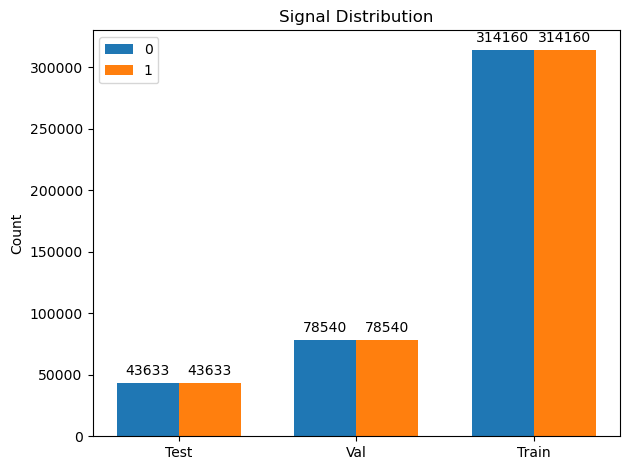

In [7]:
# Usage
file_paths = ["/kaggle/input/jet-images-train-val-test/jet-images_test.hdf5", "/kaggle/input/jet-images-train-val-test/jet-images_val.hdf5", "/kaggle/input/jet-images-train-val-test/jet-images_train.hdf5"]
plot_signal_distribution(file_paths)